In [1]:
import datetime
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import sys
import tensorflow as tf

from collections import Counter
from imblearn.over_sampling import SMOTE
from keras import layers
from keras import models
from keras import regularizers
from keras import utils
from keras.utils import to_categorical
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate # to run validation on multiple metrics
from sklearn.model_selection import KFold
from tensorflow import keras
from tensorflow.keras.models import save_model


%matplotlib inline

# Preparation Steps

In [2]:
# folders
home = os.getenv("HOME")
nlp_repo = os.path.join(home, 'git/nlp-product-sentiment-classification')

# data
train_csv_path = os.path.join(nlp_repo, 'data/03_processed/Train.csv')
train_descr = pd.read_csv(train_csv_path)

test_csv_path = os.path.join(nlp_repo, 'data/03_processed/Test.csv')
test_descr = pd.read_csv(test_csv_path)

# encoded tokens
preprocessed_corpus_path_TF = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF.p')

preprocessed_corpus_path_TF_oh = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF_oh.p')

# Define Parameter Dictionary

This dictionary contains all the parameters necessary for the model training. It is going to be saved with the trained model in order to log it. 


Inputs before running a new experiment: 
1. Define experiment name
2. Define model architecture and hyperparameters

In [3]:
logging = True

saving = True

PARAMS = {

    # Define experiment name:
    'experiment_name': 'all_models_no_counter_overfitting',

    # List of models
    'model_type': ['bow', 'fc_emb', 'fc_transf', 'lstm', 'lstm_transf', 'conv1d', 'conv1d_transf'],

    # Parameters general:
    'number_of_classes': len(np.unique(train_descr['Sentiment'])),
    'n_splits': 4,
    'seed': 42,
    'batch_size': 32,  # [16, 32, 64],
    'epochs': 15,
    'hidden_units': 32,  # [16, 32, 64],

    # NLP Parameters
    # max_words = vocabulary size = our samples - number of most frequent words.
    # I set it to 10.000, although in this case there are less.
    # I do this to parametise the code.
    # Aleternatively, I can set it to the length of our vocabulary = word_index
    'max_words': 10000,

    # embedding_size = embedding dimensionality
    'embedding_size': 30,  # [10, 20, 30, 100],

    # Parameters for pre-trained word embeddings:
    'embedding_dim': 100,

    # Parameters for the Conv1D:
    'conv_window': 5,  # [3, 5, 7],

    # Cross-fold validation:
    'k': 4,
}

logdir = f'logs/experiments/{PARAMS["experiment_name"]}_' + \
    datetime.datetime.now().strftime("%Y_%m_%d-%H:%M")
logdir_tb = f'logs/tensorboard/experiments/{PARAMS["experiment_name"]}_' + \
    datetime.datetime.now().strftime("%Y_%m_%d-%H:%M")

# create logging folder and tensorboard callback function
if logging:
    print(f'Log results to {logdir}')
    if not os.path.exists(logdir):
        os.makedirs(logdir)

    tensorboard_callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir_tb)]

else:
    logdir = ''
    logdir_tb = ''
    tensorboard_callbacks = []

Log results to logs/experiments/all_models_no_counter_overfitting_2020_12_09-18:43


# Load Tokens and Vocabulary

In [4]:
def load_data(path_to_corpus, one_hot=False):
    if not one_hot:
        sequences, word_index = pd.read_pickle(path_to_corpus)

        # max_len = sequence length - the text is cut off after this number of words
        # in this case it is defined as the maximum sequence length in our list of tokenised sequences
        max_len = np.max([len(x) for x in sequences])
        data = tf.keras.preprocessing.sequence.pad_sequences(
            sequences, maxlen=max_len)
    else:
        sequences, word_index = pd.read_pickle(path_to_corpus)
        data = sequences

    labels = train_descr.loc[:, 'Sentiment'].to_list()

    return sequences, word_index, data, labels

for bag-of-words with one-hot encoded tokens

In [5]:
sequences_oh, word_index_oh, data_oh, labels_oh = load_data(
    preprocessed_corpus_path_TF_oh, one_hot=True)
sequences_oh.shape

(6364, 10000)

for the models with embedding layer

In [6]:
sequences, word_index, data, labels = load_data(preprocessed_corpus_path_TF)
print(f'Shape of sequences after padding is {data.shape}')

Shape of sequences after padding is (6364, 25)


Add max_len to parameters dictionary

In [7]:
max_len = np.max([len(x) for x in sequences])
PARAMS['max_len'] = max_len

# Preparation for the Pre-Trained Embeddings

In [8]:
glove_dir = './glove.6B'

In [9]:
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [10]:
embedding_matrix = np.zeros((PARAMS['max_words']+1, PARAMS['embedding_dim']))

for word, i in word_index.items():
    if i < PARAMS['max_words']:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(10001, 100)


# Train-Test Split

In [11]:
def train_test_split(data, labels):
    dimensions_labels = PARAMS['number_of_classes']

    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)

    data = data[indices]
    labels = np.asarray(labels)
    labels = labels[indices]

    training_samples = int(0.8 * len(data))

    x_train = data[:training_samples]
    y_train = labels[:training_samples]

    x_test = data[training_samples:]
    y_test = labels[training_samples:]

    y_train_oh = tf.one_hot(indices=y_train, depth=dimensions_labels)
    y_train_oh = np.asarray(y_train_oh)

    y_test_oh = tf.one_hot(indices=y_test, depth=dimensions_labels)
    y_test_oh = np.asarray(y_test_oh)

    return x_train, y_train_oh, x_test, y_test_oh

In [12]:
x_train, y_train, x_test, y_test = train_test_split(data, labels)

x_train_oh, y_train_oh, x_test_oh, y_test_oh = train_test_split(
    data_oh, labels_oh)

# Oversample the Minority Classes

In [13]:
def oversample_smote(x_train, y_train):
    oversample = SMOTE()
    x_train, y_train = oversample.fit_resample(x_train, y_train)

    return x_train, y_train


def plot_classes(y_train):
    counter = Counter(y_train)
    for k, v in counter.items():
        per = v / len(y_train) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    # plot the distribution
    plt.bar(counter.keys(), counter.values())
    plt.show()

# Generate a Model

In [14]:
metrics = [
    keras.metrics.CategoricalAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')]

In [15]:
def generate_model(model_type, params_dict, ):
    """
    This function compiles a model according to the chosen model_type
    Args: 
        - model_type - which model type is to be used
        - params_dict - dictionary with parameters for the model

    Returns: 
        - a compiled model
    """

    # set parameters
    hidden_units = params_dict['hidden_units']
    dimensions_labels = params_dict['number_of_classes']
    max_words = params_dict['max_words']
    max_len = params_dict['max_len']
    embedding_size = params_dict['embedding_size']
    embedding_dim = params_dict['embedding_dim']
    conv_window = params_dict['conv_window']

    # fully connected bag-of-words
    if model_type == PARAMS['model_type'][0]:
        model = models.Sequential()
        model.add(layers.Dense(hidden_units, activation='relu',
                               input_shape=(max_words, )))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

    # fully connected & "homegrown" embeddings layer
    elif model_type == PARAMS['model_type'][1]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_size, input_length=max_len))
        model.add(layers.Flatten())
        model.add(layers.Dense(hidden_units, activation='relu'))
        # input_shape=(max_words, )))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

    # fully connected & a pre-trained embeddings layer
    elif model_type == PARAMS['model_type'][2]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_dim, input_length=max_len))
        model.add(layers.Flatten())
        model.add(layers.Dense(hidden_units, activation='relu'))
        # input_shape=(max_words, )))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

        model.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
        model.layers[0].trainable = False

    # lstm with "homegrowm" embeddings layer
    elif model_type == PARAMS['model_type'][3]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_dim, input_length=max_len))
        model.add(layers.LSTM(hidden_units))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

    # lstm with pre-trained embeddings layer
    elif model_type == PARAMS['model_type'][4]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_dim, input_length=max_len))
        model.add(layers.LSTM(hidden_units))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

        model.layers[0].set_weights(
            [embedding_matrix])  # !!!! important !!!!
        model.layers[0].trainable = False

    # conv1D with "homegrown" embeddings layer
    elif model_type == PARAMS['model_type'][5]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_size, input_length=max_len))

        model.add(layers.Conv1D(
            hidden_units,  # features to be extracted
            conv_window,  # convolutional window size
            activation='relu',
        ))
        model.add(layers.Conv1D(hidden_units, conv_window, activation='relu'))
        model.add(layers.GlobalMaxPooling1D())
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

    # conv1D with pre-trained embeddings layer
    elif model_type == PARAMS['model_type'][6]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_dim, input_length=max_len))

        model.add(layers.Conv1D(hidden_units, conv_window, activation='relu',))
        model.add(layers.Conv1D(hidden_units, conv_window, activation='relu'))
        model.add(layers.GlobalMaxPooling1D())
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

        model.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
        model.layers[0].trainable = False

    model.summary()

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=metrics
    )

    return model

# Training with Cross-Validation (incl. Upsampling)

* Due to the small data quantity, cross-validation will be used to train the models.
* Furthermore, as the classes are imbalanced, an oversampling will be introduced. ! It is important to generate the training and validation sets BEFORE the upsampling. Otherwise the exact same observations could be present in both the train and validation sets, i.e. data leakage would occur. This can allow the model to simply memorize specific data points and cause overfitting and poor generalization on unseen data. 
* The oversampling will be applied only on the train set in order to ensure that the model generalises well on unseen data (validation set and ultimately test set)

In [16]:
def train_with_cross_val(k, model, model_type, train_data, train_labels, epochs, batch_size):
    """
    This function applies a k-fold cross-validation and saves the model history per fold & epoch.
    Args: 
        - k - number of folds
        - model - compiled model
        - model_type - which model type is to be used
        - train_data - the tokenised, padded and shuffled sequences
        - train_labels - labels 
        - epochs - number of epochs
        - batch_size - batch size
    """
    num_val_samples = len(train_data) // k

    for i in range(k):
        print('processing fold #', i)
        val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
        val_labels = train_labels[i *
                                  num_val_samples:(i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples],
             train_data[(i + 1) * num_val_samples:]],
            axis=0)

        partial_train_labels = np.concatenate(
            [train_labels[:i * num_val_samples],
             train_labels[(i + 1) * num_val_samples:]],
            axis=0
        )

        partial_train_data_ovs, partial_train_labels_ovs = oversample_smote(
            partial_train_data, partial_train_labels)

        history = model.fit(
            partial_train_data_ovs, partial_train_labels_ovs,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            validation_data=(val_data, val_labels),
            # callbacks=tensorboard_callbacks
        )

        np.save(f'history_{model_type}_fold_{i}.npy', history.history)

    if saving:
        path = os.path.join(logdir, f'{model_type}')
        model.save(path)

# Baseline Model

Idea Model: https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/

Metrics: https://scikit-learn.org/stable/modules/model_evaluation.html


* As the Fully Connected NN model's the precision, recall and f1 are calculcated unweighted, precision, recall & f1 are chosen to be macro
* According to the sklearn-documentation this method calculates the metrics for each label, and finds their unweighted mean and does not take label imbalance into account.
* Example documentation for precision: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

Note: test_[metric] is validation and therefore comparable to the val_[metric] of the model.

In [17]:
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

In [18]:
model_base = DummyClassifier(strategy='most_frequent')

In [19]:
cv = KFold(n_splits=PARAMS['k'], random_state=PARAMS['seed'])
   
scores = cross_validate(
        model_base, x_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [20]:
for metric, score in scores.items():
    print(f'Mean {metric}: %.3f (%.3f)' %
          (np.mean(score), np.std(score)))

Mean fit_time: 0.001 (0.000)
Mean score_time: 0.010 (0.000)
Mean test_accuracy: 0.584 (0.006)
Mean test_precision_macro: 0.146 (0.002)
Mean test_recall_macro: 0.250 (0.000)
Mean test_f1_macro: 0.184 (0.001)


# Train the Model per Type

In [21]:
#history_all = pd.DataFrame()
for model_type in PARAMS['model_type']:
    model = generate_model(model_type, PARAMS)

    if model_type == PARAMS['model_type'][0]:
        train_with_cross_val(PARAMS['k'], model, model_type, x_train_oh,
                             y_train_oh, PARAMS['epochs'], PARAMS['batch_size'])
    else:
        train_with_cross_val(
            PARAMS['k'], model, model_type, x_train, y_train, PARAMS['epochs'], PARAMS['batch_size'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 321,220
Trainable params: 321,220
Non-trainable params: 0
_________________________________________________________________
processing fold # 0


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_09-18:43/bow/assets
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 30)            300030    
_________________________________________________________________
flatten (Flatten)            (None, 750)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                24032     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
____________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_09-18:43/fc_emb/assets
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 100)           1000100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                80032     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 132       
Total params: 1,081,320
Trainable params: 81,220
Non-trainable params: 1,000,100
______________________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_09-18:43/fc_transf/assets
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 100)           1000100   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 132       
Total params: 1,019,368
Trainable params: 1,019,368
Non-trainable params: 0
________________________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_09-18:43/lstm/assets
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 25, 100)           1000100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 132       
Total params: 1,019,368
Trainable params: 19,268
Non-trainable params: 1,000,100
________________________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_09-18:43/lstm_transf/assets
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 25, 30)            300030    
_________________________________________________________________
conv1d (Conv1D)              (None, 21, 32)            4832      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 32)            5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 132       
Total params: 310,146
Trainable params: 310,146
Non-trainable params: 0
__________________________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_09-18:43/conv1d/assets
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 25, 100)           1000100   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21, 32)            16032     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 17, 32)            5152      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 132       
Total params: 1,021,416
Trainable params: 21,316
Non-trainable params: 1,000,100
______________________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_09-18:43/conv1d_transf/assets


# Evaluate the Models

### Generate a Metrics Dataframe

In [22]:
history_all_df = pd.DataFrame()

for model_type in PARAMS['model_type']:
    for i in range(PARAMS['k']):
        history = np.load(
            f'history_{model_type}_fold_{i}.npy', allow_pickle='TRUE').item()
        history['model_type'] = model_type

        history_df = pd.DataFrame(history)

        history_df['f1'] = 2 * history_df.precision * \
            history_df.recall/(history_df.precision + history_df.recall)
        history_df['f1'] = history_df['f1'].fillna(0)
        history_df['val_f1'] = 2 * history_df.val_precision * \
            history_df.val_recall / \
            (history_df.val_precision + history_df.val_recall)
        history_df['val_f1'] = history_df['val_f1'].fillna(0)

        history_all_df = history_all_df.append(history_df)

history_all_df
history_all_df_pivot = history_all_df.pivot_table(columns=['model_type'],
                                                  values=['loss', 'val_loss', 'accuracy', 'val_accuracy', 'precision', 'val_precision', 'f1', 'val_f1'])

In [23]:
history_all_df

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,model_type,f1,val_f1
0,0.687035,0.746101,0.878014,0.532496,0.928124,0.618711,0.630677,0.578616,bow,0.662936,0.603526
1,0.225142,0.910854,0.916566,0.906737,1.085404,0.627358,0.633575,0.617138,bow,0.911625,0.625249
2,0.138270,0.947682,0.948654,0.946599,1.286554,0.628931,0.630192,0.620283,bow,0.947625,0.625198
3,0.103617,0.962305,0.963116,0.961655,1.482527,0.632862,0.634554,0.626572,bow,0.962385,0.630538
4,0.083549,0.968696,0.968997,0.968263,1.621719,0.633648,0.634921,0.628931,bow,0.968630,0.631912
...,...,...,...,...,...,...,...,...,...,...,...
10,0.299587,0.899978,0.923195,0.875112,0.795208,0.729560,0.759932,0.706761,conv1d_transf,0.898511,0.732383
11,0.275233,0.912746,0.930598,0.889113,0.812789,0.725629,0.742251,0.715409,conv1d_transf,0.909383,0.728583
12,0.242709,0.929884,0.943652,0.911626,0.950432,0.693396,0.714760,0.677673,conv1d_transf,0.927363,0.695722
13,0.223826,0.938396,0.951425,0.923611,0.917222,0.701258,0.710893,0.682390,conv1d_transf,0.937312,0.696350


In [24]:
history_all_df_pivot

model_type,bow,conv1d,conv1d_transf,fc_emb,fc_transf,lstm,lstm_transf
accuracy,0.980866,0.926242,0.791705,0.939137,0.809931,0.897759,0.659458
f1,0.979515,0.917465,0.770597,0.932533,0.795471,0.886649,0.614390
loss,0.051659,0.214036,0.551964,0.154996,0.450602,0.251413,0.755139
precision,0.983324,0.943008,0.839179,0.956290,0.877011,0.923075,0.740098
val_accuracy,0.860168,0.794706,0.665055,0.810469,0.673428,0.774934,0.705005
val_f1,0.859756,0.788862,0.652090,0.807000,0.670208,0.770474,0.691337
val_loss,0.596501,0.791594,0.897887,0.727199,1.117501,1.066682,0.778647
val_precision,0.861305,0.812233,0.707665,0.819189,0.717141,0.788877,0.752630


### Pick the 2 models with the highest F1-score

* All of the models outperform the baseline model in all the metrics
* The models before regularisation with the best F1-score are the bag-of-words and the "homegrown" embeddings
* These two models will be optimised further and used for the final multi-input model

In [25]:
history_all_df_pivot.idxmax(axis=1)

accuracy                 bow
f1                       bow
loss             lstm_transf
precision                bow
val_accuracy             bow
val_f1                   bow
val_loss           fc_transf
val_precision            bow
dtype: object

In [26]:
history_all_df_pivot.loc['val_f1', ].max()

0.8597559040871734

### Generate Summary Figures

In [27]:
history_all_grouped = history_all_df.groupby('model_type').mean()
history_all_grouped = history_all_grouped.reset_index()
history_all_grouped

,model_type,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,f1,val_f1
0,bow,0.051659,0.980866,0.983324,0.977119,0.596501,0.860168,0.861305,0.858255,0.979515,0.859756
1,conv1d,0.214036,0.926242,0.943008,0.904269,0.791594,0.794706,0.812233,0.774358,0.917465,0.788862
2,conv1d_transf,0.551964,0.791705,0.839179,0.725267,0.897887,0.665055,0.707665,0.611989,0.770597,0.652090
3,fc_emb,0.154996,0.939137,0.956290,0.919192,0.727199,0.810469,0.819189,0.797838,0.932533,0.807000
4,fc_transf,0.450602,0.809931,0.877011,0.740485,1.117501,0.673428,0.717141,0.634434,0.795471,0.670208
5,lstm,0.251413,0.897759,0.923075,0.864735,1.066682,0.774934,0.788877,0.756355,0.886649,0.770474
6,lstm_transf,0.755139,0.659458,0.740098,0.534646,0.778647,0.705005,0.752630,0.649502,0.614390,0.691337


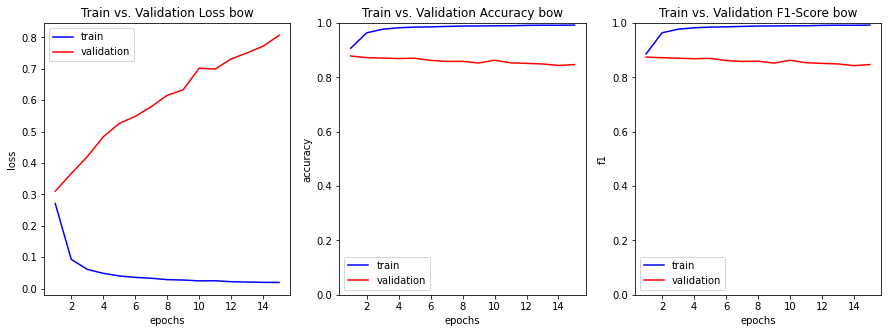

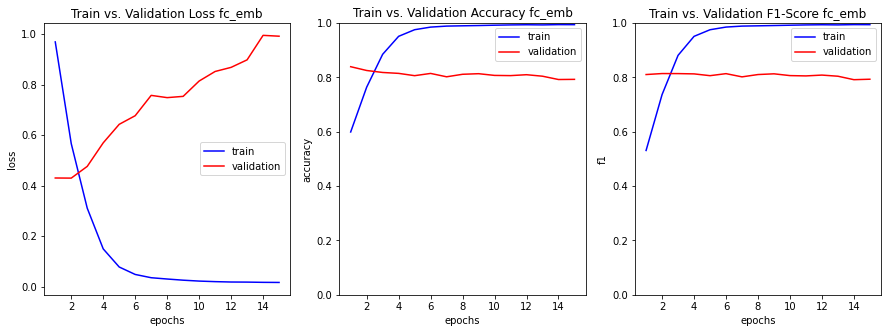

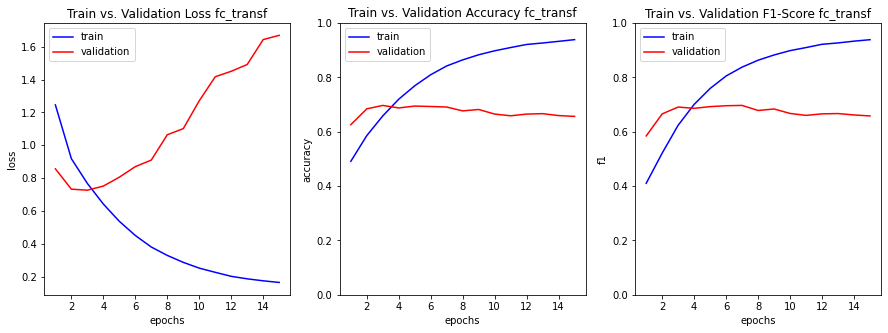

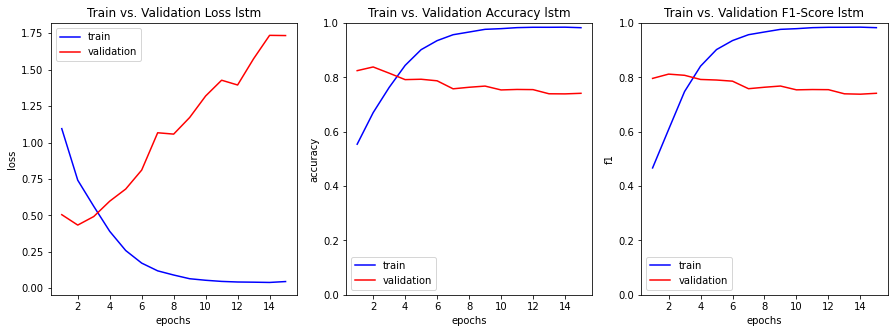

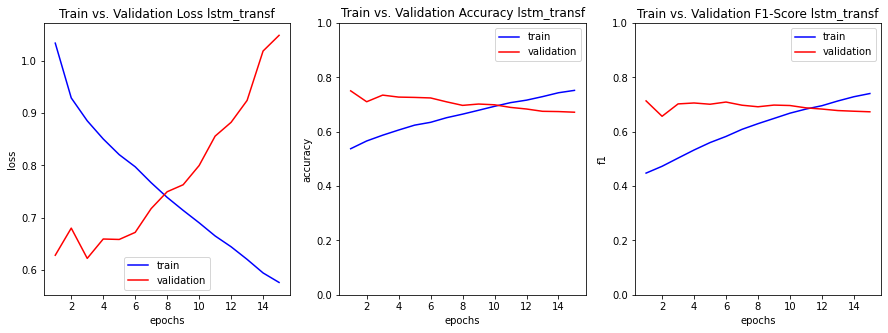

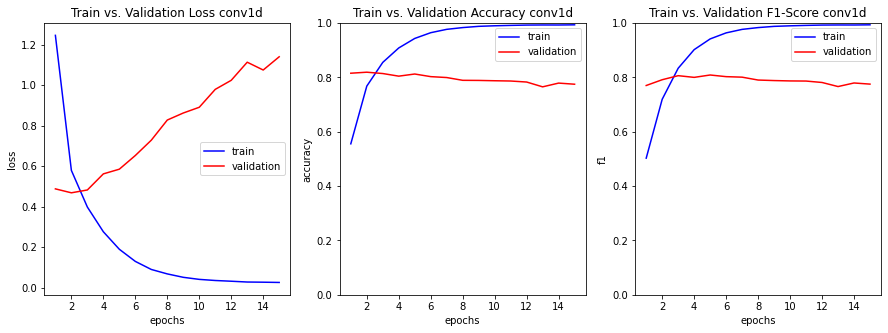

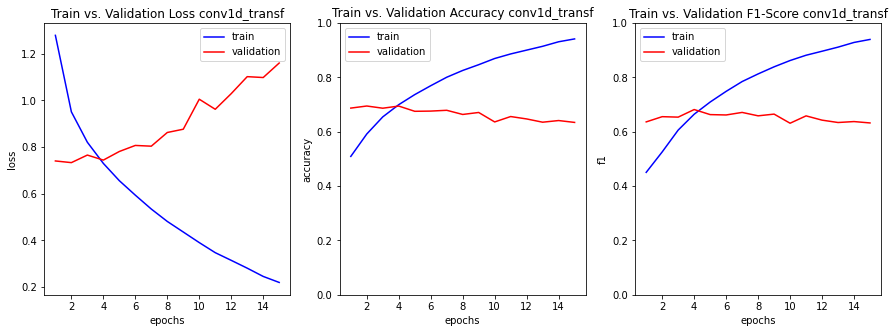

In [28]:
for model_type in PARAMS['model_type']:
    fig = plt.figure(figsize=(15, 5))
    ax = plt.subplot(131)

    epochs = PARAMS['epochs']
    epochs_graph = range(1, PARAMS['epochs'] + 1)
    folds = PARAMS['k']

    mask = history_all_df.loc[:, 'model_type'] == model_type

    loss_all = history_all_df.loc[mask, 'loss'].to_list()
    loss_prep = [loss_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
    loss = [np.mean([x[i] for x in loss_prep]) for i in range(epochs)]

    val_loss_all = history_all_df.loc[mask, 'val_loss'].to_list()
    val_loss_prep = [
        val_loss_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
    val_loss = [np.mean([x[i] for x in val_loss_prep]) for i in range(epochs)]

    accuracy_all = history_all_df.loc[mask, 'accuracy'].to_list()
    accuracy_prep = [
        accuracy_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
    accuracy = [np.mean([x[i] for x in accuracy_prep]) for i in range(epochs)]

    val_accuracy_all = history_all_df.loc[mask, 'val_accuracy'].to_list()
    val_accuracy_prep = [val_accuracy_all[i *
                                          epochs:(i + 1) * epochs] for i in range(folds)]
    val_accuracy = [np.mean([x[i] for x in val_accuracy_prep])
                    for i in range(epochs)]

    f1_all = history_all_df.loc[mask, 'f1'].to_list()
    f1_prep = [f1_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
    f1 = [np.mean([x[i] for x in f1_prep]) for i in range(epochs)]

    val_f1_all = history_all_df.loc[mask, 'val_f1'].to_list()
    val_f1_prep = [val_f1_all[i * epochs:(i + 1) * epochs]
                   for i in range(folds)]
    val_f1 = [np.mean([x[i] for x in val_f1_prep]) for i in range(epochs)]

    plt.plot(epochs_graph, loss, 'b')
    plt.plot(epochs_graph, val_loss, 'r')
    #plt.ylim([0, 1])
    ax.set_ylabel('loss')
    ax.set_xlabel('epochs')
    ax.legend(['train', 'validation'])
    plt.title(f'Train vs. Validation Loss {model_type}')

    ax = plt.subplot(132)
    plt.plot(epochs_graph, accuracy, 'b')
    plt.plot(epochs_graph, val_accuracy, 'r')
    plt.ylim([0, 1])
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epochs')
    ax.legend(['train', 'validation'])
    plt.title(f'Train vs. Validation Accuracy {model_type}')

    ax = plt.subplot(133)
    plt.plot(epochs_graph, f1, 'b')
    plt.plot(epochs_graph, val_f1, 'r')
    plt.ylim([0, 1])
    ax.set_ylabel('f1')
    ax.set_xlabel('epochs')
    ax.legend(['train', 'validation'])
    plt.title(f'Train vs. Validation F1-Score {model_type}')

    if logging:
        if not os.path.exists(os.path.join(logdir, 'figures')):
            os.makedirs(os.path.join(logdir, 'figures'))
        fig.savefig(os.path.join(
            logdir, f'figures/loss_accuracy_training_{model_type}.png'), bbox_inches='tight')

In [29]:
def precision_recall(history_all_df, logging=False, logpath=''):
    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(111)
    sns.scatterplot(data=history_all_df, x='val_recall', y='val_precision')
    plt.xlim([0, 1.05])
    plt.ylim([0, 1.05])
    ax.legend(title='precision-recall',
              bbox_to_anchor=(1.05, 1), loc='upper left')

    if logging:
        fig.savefig(logpath, bbox_inches='tight')

    return fig

No handles with labels found to put in legend.


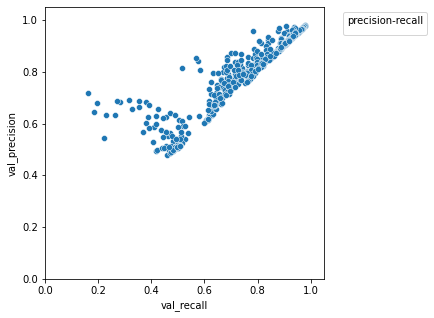

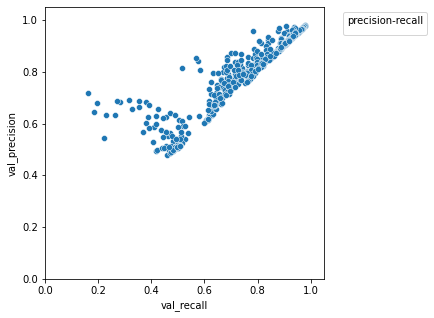

In [30]:
precision_recall(history_all_df)